In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import math

In [3]:
# Changing the time from 00.00.00 to an integer
def time_to_int(time):
  if (time == float):
    return time
  time_str = str(time)
  time_series = time_str.rsplit(':')
  if ('\\N' in time_str):
    return None
  if (not '.' in time_str):
    return None
  if (len(time_series) > 1):
    return int(time_series[0]) * 60 + float(time_series[1])
  else:
    return float(time_series[0])

In [4]:
races = pd.read_csv('data/races.csv')
d_standings = pd.read_csv('data/driver_standings.csv')
c_standings = pd.read_csv('data/constructor_standings.csv')
quali = pd.read_csv('data/qualifying.csv')
pit_stops = pd.read_csv('data/pit_stops.csv')
lap_times = pd.read_csv('data/lap_times.csv')
results = pd.read_csv('data/results.csv')
circuits = pd.read_csv('data/circuits.csv')
drivers = pd.read_csv('data/drivers.csv')
constructor = pd.read_csv('data/constructors.csv')
status = pd.read_csv('data/status.csv')

In [9]:
def race_info(raceId):
  _races = races
  _r = _races.query(f'raceId  == {raceId}')
  if (_r.empty):
    return None, None, None
  _year = _r['year'].item()
  _round = _r['round'].item()
  _circuitId = _r['circuitId'].item()
  return _year, _round, _circuitId

def circuit_info(circuitId):
  _circuits = circuits
  _c = _circuits.query(f'circuitId  == {circuitId}')
  if (_c.empty):
    return None, None, None
  _name = _c['name'].item()
  _location = _c['location'].item()
  _country = _c['country'].item()
  return _name, _location, _country

def driver_info(id):
  _drivers = drivers
  _d = _drivers.query(f'driverId  == {id}')
  if (_d.empty):
    return None, None, None, None, None, None
  _number = _d['number'].item()
  _code = _d['code'].item()
  _forename = _d['forename'].item()
  _surname = _d['surname'].item()
  _dob = _d['dob'].item()
  _nationality = _d['nationality'].item()
  return _number, _code, _forename, _surname, _dob, _nationality

def constructor_info(id):
  _constructor = constructor
  _c = _constructor.query(f'constructorId  == {id}')
  if (_c.empty):
    return None, None
  _name = _c['name'].item()
  _nationality = _c['nationality'].item()
  return _name, _nationality

def status_info(id):
  _status = status
  _s = _status.query(f'statusId == {id}')
  if (_s.empty):
    return None
  _sstr = _s['status'].item()
  return _sstr

In [10]:
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
for year in years:
  if not os.path.exists(f'races_npy/{year}'):
        os.makedirs(f'races_npy/{year}')

In [12]:
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

status = pd.read_csv('data/status.csv')

sbin = {}

for y in years:

  cur_year = os.listdir(f'races/{y}/')
  for r in cur_year:
    
    cur_race = pd.read_csv(f'races/{y}/{r}')

    for j in range(20):
      for i in range(len(cur_race) - 1):
          s = cur_race[f'status{j+1}'][i]
          if (s.item() in sbin):
            sbin[s.item()] += 1
          else:
            sbin [s.item()] = 1

{0.0: 188101, 81.0: 114, 4.0: 6007, 6.0: 911, 3.0: 2657, 22.0: 859, 5.0: 1944, 31.0: 1191, 11.0: 880, 61.0: 203, 13.0: 66, 43.0: 142, 76.0: 12, 12.0: 317, 26.0: 176, 32.0: 106, 10.0: 578, 65.0: 38, 23.0: 1266, 54.0: 518, 40.0: 151, 45.0: 22, 91.0: 67, 9.0: 505, 20.0: 430, 130.0: 1156, 69.0: 112, 29.0: 222, 36.0: 287, 27.0: 99, 7.0: 145, 63.0: 24, 34.0: 102, 18.0: 16, 51.0: 69, 39.0: 7, 131.0: 972, 8.0: 19, 101.0: 192, 79.0: 23, 44.0: 193, 47.0: 85, 75.0: 428, 132.0: 91, 14.0: 20, 33.0: 41, 16.0: 6, 37.0: 75, 135.0: 31, 96.0: 1, 84.0: 169, 25.0: 178, 30.0: 23, 136.0: 12, 105.0: 49, 38.0: 53, 137.0: 30, 60.0: 4, 2.0: 2, 15.0: 5, 138.0: 35, 21.0: 37, 139.0: 16}
63


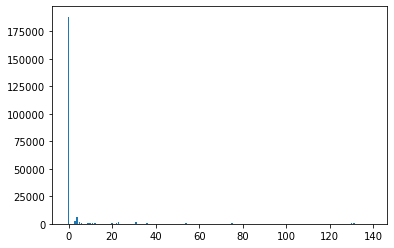

In [13]:
sbin = {k: sbin[k] for k in sbin if not math.isnan(k)}
print(sbin)
print(len(sbin))
plt.bar(sbin.keys(), sbin.values());

In [14]:
sbinstr = {status_info(k): sbin[k] for k in sbin}

In [30]:
statdict = {
    'No problem': [],
    'Lapped': [],
    'Accidents/Collisions': [],
    'Spun off': [],
    'Car issues': [],
    'Other': []
}
statbin = {
    'No problem': 0,
    'Lapped': 0,
    'Accidents/Collisions': 0,
    'Spun off': 0,
    'Car issues': 0,
    'Other': 0
}
for k in sbin.keys():
  s = status_info(k)
  if (s == None):
    statdict['No problem'].append(k)
    statbin['No problem'] += sbin[k]
  elif ('Lap' in s):
    statdict['Lapped'].append(k)
    statbin['Lapped'] += sbin[k]
  elif ('Accident' in s or 'Collision' in s):
    statdict['Accidents/Collisions'].append(k)
    statbin['Accidents/Collisions'] += sbin[k]
  elif ('Spun' in s):
    statdict['Spun off'].append(k)
    statbin['Spun off'] += sbin[k]
  elif ('%' in s or 
        'qualify' in s or 
        'Excluded' in s or
        'Injur' in s or
        'Not' in s or
        'Retired' in s or
        'Withdrew' in s):
    statdict['Other'].append(k)
    statbin['Other'] += sbin[k]
  else:
    statdict['Car issues'].append(k)
    statbin['Car issues'] += sbin[k]

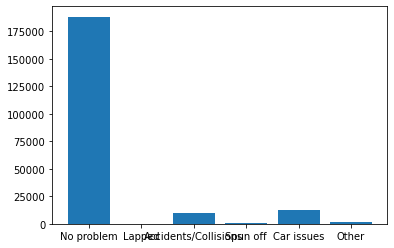

In [31]:
plt.bar(statbin.keys(), statbin.values());

In [19]:
statbin['No problem']

188101

In [17]:
statbin['Lapped']

1332

In [21]:
statbin['Accidents/Collisions']

9820

In [22]:
statbin['Spun off']

430

In [23]:
statbin['Car issues']

10783

In [24]:
statbin['Other']

1824

In [29]:
status[status['statusId'] == 9]

,statusId,status
8,9,Hydraulics


In [15]:
stat_emb = [
  [4.0, 3.0, 130.0], # Accident/Collision
  [22.0, 5.0, 10.0, 23.0, 44.0, 47.0, 30.0, 32.0, 8.0, 38.0, 43.0, 85.0, 9.0, 86.0, 6.0, 2.0, 7.0, 87.0, 71.0, 41.0, 46.0, 37.0, 65.0, 78.0, 25.0, 74.0, 75.0, 26.0, 51.0, 40.0, 79.0, 36.0, 83.0, 80.0, 21.0, 69.0, 72.0, 70.0, 27.0, 60.0, 63.0, 29.0, 64.0, 66.0, 56.0, 59.0, 61.0, 42.0, 39.0, 48.0, 49.0, 34.0, 35.0, 28.0, 24.0, 33.0, 129.0, 76.0, 91.0, 131.0, 101.0, 132.0, 135.0,  84.0,  136.0,  105.0,  137.0,  138.0,  139.0], # Car issues
  [11.0,  13.0,  12.0,  14.0,  17.0,  15.0,  16.0, 18.0,  55.0,  58.0,  45.0, 88.0], # Lapped
  [0.0], # No problem
  [77.0, 73.0, 82.0, 81.0, 62.0, 54.0, 31.0, 96.0], # Other
  [20.0] #'Spun off'
] 

def stat_embed(id):
  _emb = np.zeros(6)
  for i in range(6):
    if id in stat_emb[i]:
      _emb[i] = 1
      return _emb
  _emb[4] = 1
  return _emb # Other

def stat_unbed(array, retired=False):
  _a = np.copy(array)
  if (retired):
    _a[3] = 0
  _i = np.argmax(_a)
  if (_i == 0):
    return 'Accident/Collision'
  elif (_i == 1):
    return 'Car Issues'
  elif (_i == 2):
    return 'Lapped'
  elif (_i == 3):
    return 'No Problem'
  elif (_i == 4):
    return 'Other'
  elif (_i == 5):
    return 'Spun off'
  else:
    return 'something is wrong'

In [16]:
def lt_embed(laptime):
  # laptime should be a float with 3 decimal places
  _lt = math.floor(laptime * 10)
  _lt_emb = []
  _ret = []
  for i in range(4):
    _lt_emb.append(int(_lt % 10))
    _lt = math.floor(_lt / 10)
  _ret = np.zeros(2)
  if (_lt_emb[-1] == 1):
    _ret[0] = 1
  elif (_lt_emb[-1] == 2):
    _ret[1] = 1
  elif (_lt_emb[-1] > 2):
    _ret[0] = 1
    _ret[1] = 1
  for i in range(3):
    _t = np.zeros(10)
    _t[_lt_emb[2 - i]] = 1
    _ret = np.append(_ret, _t)
  return _ret

def lt_unbed(l_array):
  _ret = 0
  if (l_array[0] >= 0.5 and l_array[1] >= 0.5):
    _ret += 300
  elif (l_array[0] >= 0.5):
    _ret += 100
  elif (l_array[1] >= 0.5):
    _ret += 200
  _ret += np.argmax(l_array[2:12]) * 10
  _ret += np.argmax(l_array[12:22]) * 1
  _ret += np.argmax(l_array[22:32]) * 0.1
  return _ret

In [17]:
l = lt_embed(123.456)
print(len(l))

32


In [19]:
u = lt_unbed(l)
print(u)

123.4


In [20]:
drivers_short = pd.read_csv('data/drivers_short.csv')
# from driverId to our id
def driver_embed_idx(driverId):
  row = drivers_short.query(f'driverId == {driverId}').index
  if (row.empty):
    return 0
  return row.item() + 1

# from our id to driverId
def driver_unbed_idx(idx):
  row = drivers_short.iloc[idx-1]
  return row['driverId']

# from our id to array
def driver_embed(idx):
  _e = np.zeros(130)
  _e[idx-1] = 1
  return _e

# from array to our id
def driver_unbed(d_array):
  return np.argmax(d_array) + 1

In [21]:
a = driver_embed(10)
print(len(a))
a

130


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
b = driver_unbed(a)
print(b)

10


In [23]:
driver_embed_idx(808)

71

In [24]:
driver_unbed_idx(71)

808

In [31]:
# to make feature size consistent, we use laptimes of top 20 drivers
class RaceDataset(torch.utils.data.Dataset):
  def __init__(self, dir):

    self.dir = dir
    self.year = 2001
    self.round = 1
    self.cache = {}

    # get a list of races in this season, should be ordered automatically
    self.cur_year = os.listdir(self.dir + f'{self.year}/')

    if (self.round < len(self.cur_year)):
      self.cur_race = pd.read_csv(self.dir + f'{self.year}/{self.cur_year[self.round - 1]}')
    else:
      self.cur_race = pd.read_csv(self.dir + f'{self.year}/{self.cur_year[-1]}')


  def set_year(self, year):
    if (year == 2021):
      return
    self.year = year
    self.cur_year = os.listdir(self.dir + f'{self.year}/')
    self.cur_year.sort()

  def set_round(self, round):
    self.round = round
    if (self.year == 2021):
      return # no data yet
    # set round, if round > number of rounds in that season, set to the last round
    if (self.round < len(self.cur_year)):
      self.cur_race = pd.read_csv(self.dir + f'{self.year}/{self.cur_year[self.round - 1]}')
    else:
      self.cur_race = pd.read_csv(self.dir + f'{self.year}/{self.cur_year[-1]}')

  def next_round(self):
    self.round += 1
    if (self.round < len(self.cur_year)):
      self.set_round(self.round)
    else:
      self.round = 1
      self.set_year(self.year+1)
      self.set_round(self.round)


  def __len__(self):
    # -1 since the last lap will always only be a label
    return len(self.cur_race) - 1

  def __getitem__(self, i):
    if (f'{self.year}_{self.round}_{i}' in self.cache):
      cur_ret, next_ret = self.cache[f'{self.year}_{self.round}_{i}']
    else:
      if not os.path.exists(f'races_npy/{self.year}/{self.round}_{i}_in.npy'):
        # Size([141])
        cur = self.cur_race.iloc[i].values[1:142] # removes index and trim size
        # replace NaN with 0
        cur[cur != cur] = 0
        cur_ret = np.zeros(130)
        cur_ret[int(cur[0])] = 1 # circuitId
        for k in range(1, 141, 7):
    
          d_id = driver_embed(driver_embed_idx(int(cur[k])))
          cur_ret = np.append(cur_ret, d_id)
    
          # 2 bits: top or top3 or top10
          d_s = np.zeros(3)
          _s = int(cur[k+1])-1
          if (_s <= 1):
            d_s[0] = 1
          if (_s <=3):
            d_s[1] = 1
          if (_s <=10):
            d_s[2] = 1
          cur_ret = np.append(cur_ret, d_s)
    
          c_s = np.zeros(2)
          _c = int(cur[k+2])-1
          if (_c <= 1):
            c_s[0] = 1
          if (_c <= 3):
            c_s[1] = 1
          cur_ret = np.append(cur_ret, c_s)
    
          pos = np.zeros(21)
          _p = int(cur[k+3])-1
          if (_p >= 21):
            _p = 20
          pos[_p] = 1
          cur_ret = np.append(cur_ret, pos)
    
          pit = np.zeros(1)
          pit[0] = int(cur[k+4])
          cur_ret = np.append(cur_ret, pit)
    
          stat = stat_embed(int(cur[k+5]))
          cur_ret = np.append(cur_ret, stat)
    
          laptime = lt_embed(float(cur[k+6]))
          cur_ret = np.append(cur_ret, laptime)
    
          rando = np.zeros(5)
          cur_ret = np.append(cur_ret, rando)
  
        np.save(f'races_npy/{self.year}/{self.round}_{i}_in.npy', cur_ret)
      else:
        cur_ret = np.load(f'races_npy/{self.year}/{self.round}_{i}_in.npy')
  
      if not os.path.exists(f'races_npy/{self.year}/{self.round}_{i}_exp.npy'):
        next = self.cur_race.iloc[i+1].values[1:142] # removes index and trim size
        # replace NaN with 0
        next[next != next] = 0
        for k in range(1, 141, 7):
          pos = np.zeros(21)
          _p = int(next[k+3])-1
          if (_p >= 21):
            _p = 20
          pos[_p] = 1
          if (k == 1):
            next_ret = pos
          else:
            next_ret = np.append(next_ret, pos)
    
          pit = np.zeros(1)
          pit[0] = int(next[k+4])
          next_ret = np.append(next_ret, pit)
    
          stat = stat_embed(int(next[k+5]))
          next_ret = np.append(next_ret, stat)
    
          laptime = lt_embed(float(next[k+6]))
          next_ret = np.append(next_ret, laptime)
  
        np.save(f'races_npy/{self.year}/{self.round}_{i}_exp.npy', next_ret)
      else:
        next_ret = np.load(f'races_npy/{self.year}/{self.round}_{i}_exp.npy')

      self.cache[f'{self.year}_{self.round}_{i}'] = cur_ret, next_ret

    return (torch.from_numpy(cur_ret), torch.from_numpy(next_ret))

In [32]:
ds = RaceDataset('races/')

In [33]:
ds[0]

(tensor([0., 1., 0.,  ..., 0., 0., 0.], dtype=torch.float64),
 tensor([1., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64))

In [34]:
len(ds[0][0])

4130

In [35]:
len(ds[0][1])

1200

In [36]:
def pos_df(lap_in, out):
  df = pd.DataFrame(columns=['code', 'driver', 'position', 'pitting', 'status', 'laptime'])
  _lap = lap_in.detach().clone().numpy()
  _o = out.detach().clone().numpy()
  _name, _loc, _country = circuit_info(np.argmax(_lap[:130]))
  for i in range(20):
    _d_idx = driver_unbed_idx(driver_unbed(_lap[130 + i * 200 : 130 + i * 200 + 130]))
    _num, _code, _fn, _ln, _, _ = driver_info(_d_idx)
    _pos = np.argmax(_o[i*60 : i*60 + 21]) + 1
    _pitting = _o[i*60+21]
    _retired = False
    if (_pos == 21):
      _retired = True
    _status = stat_unbed(_o[i*60 + 22: i*60 + 28], _retired)
    _time = lt_unbed(_o[i*60 + 28: ])
    df = df.append({
        'code': f'{_code}',
        'driver': f'{_fn} {_ln}',
        'position': _pos,
        'pitting': _pitting,
        'status': _status,
        'laptime': _time
    }, ignore_index=True)

  df = df.sort_values(by=['position', 'laptime'], ascending=[True, False])
  return _name, _loc, _country, df

In [41]:
_, _, _, df = pos_df(ds[0][0], ds[0][1])

In [42]:
df

,code,driver,position,pitting,status,laptime
0,MSC,Michael Schumacher,1,0.0,No Problem,97.1
2,\N,Mika Häkkinen,2,0.0,No Problem,98.4
3,\N,Heinz-Harald Frentzen,3,0.0,No Problem,99.6
4,SCH,Ralf Schumacher,4,0.0,No Problem,101.3
1,BAR,Rubens Barrichello,5,0.0,No Problem,101.4
6,TRU,Jarno Trulli,6,0.0,No Problem,102.3
5,COU,David Coulthard,7,0.0,No Problem,102.8
7,VIL,Jacques Villeneuve,8,0.0,No Problem,103.3
9,HEI,Nick Heidfeld,9,0.0,No Problem,104.2
8,\N,Olivier Panis,10,0.0,No Problem,104.6


In [43]:
ds[0][0].shape

torch.Size([4130])

In [44]:
# Returns a tensor with the size of in but content of out
def out_to_in(in_, out_, random=False):
  _ret = in_.detach().clone().numpy()
  _o = out_.detach().clone().numpy()
  _o = _o.reshape([1200])
  _ret = _ret.reshape([4130])
  j = 0
  for i in range(0, 20):
    _ret[130 + i*200 + 135: i*200 + 130 + 195] = _o[j*60: (j+1) * 60]
    if (random):
      _ret[i * 200 + 130 + 195: (i+1) * 200 + 130] = np.random.uniform(0, 10, [5])
    j += 1

  return torch.from_numpy(_ret).float()

In [45]:
outfromin = out_to_in(ds[0][0], ds[0][1])

In [46]:
print(outfromin)

tensor([0., 1., 0.,  ..., 0., 0., 0.])


In [47]:
_, _, _, df2 = pos_df(outfromin, ds[0][1])

In [48]:
df2

,code,driver,position,pitting,status,laptime
0,MSC,Michael Schumacher,1,0.0,No Problem,97.1
2,\N,Mika Häkkinen,2,0.0,No Problem,98.4
3,\N,Heinz-Harald Frentzen,3,0.0,No Problem,99.6
4,SCH,Ralf Schumacher,4,0.0,No Problem,101.3
1,BAR,Rubens Barrichello,5,0.0,No Problem,101.4
6,TRU,Jarno Trulli,6,0.0,No Problem,102.3
5,COU,David Coulthard,7,0.0,No Problem,102.8
7,VIL,Jacques Villeneuve,8,0.0,No Problem,103.3
9,HEI,Nick Heidfeld,9,0.0,No Problem,104.2
8,\N,Olivier Panis,10,0.0,No Problem,104.6


In [49]:
asdf = [1,2,3]
max(asdf)

3

In [50]:
class CustomeLoader():
  def __init__(self, ds, batchsize):
    self.ds = ds
    self.batchsize = batchsize
    self.reset()

  def reset(self):
    self.ds.set_year(2001)
    self.ds.set_round(1)
    self.totalraces = 0
    self.totallaps = 0
    while (self.ds.year != 2020):
      self.totalraces += 1
      self.totallaps += len(self.ds)
      self.ds.next_round()
    
    self.num_batches = math.ceil(float(self.totallaps) / self.batchsize)
    self.cur_start_year = 2001
    self.cur_start_round = 1
    self.cur_start_lap = 0
    self.sizes = []
    # number of laps in burrent batch
    for i in range(self.batchsize):
      self.sizes.append(len(self.ds))
      self.ds.next_round()
      if (ds.year == 2020):
        break
    # reset cur start year and round
    self.ds.set_year(self.cur_start_year)
    self.ds.set_round(self.cur_start_round)
    self.cur_batch_len = max(self.sizes)
    self.cur_batch = self.get_cur_batch()

  
  def get_cur_batch(self):
    for i in range(self.batchsize):
      if (len(self.ds) > self.cur_start_lap):
        in_ = self.ds[self.cur_start_lap][0].unsqueeze(0).unsqueeze(0).float()
        exp_ = self.ds[self.cur_start_lap][1].unsqueeze(0).unsqueeze(0).float()
      else:
        in_ = torch.from_numpy(np.zeros(4130)).unsqueeze(0).unsqueeze(0).float()
        exp_ = torch.from_numpy(np.zeros(1200)).unsqueeze(0).unsqueeze(0).float()
      if (i == 0):
        _bi = in_
        _bo = exp_
      else:
        _bi = torch.cat((_bi, in_), 0)
        _bo = torch.cat((_bo, exp_), 0)

      self.ds.next_round()
      if (self.ds.year == 2020):
        break
    self.ds.set_year(self.cur_start_year)
    self.ds.set_round(self.cur_start_round)
    return  _bi, _bo
  
  def next_batch(self):
    if (self.cur_start_lap + 1 < self.cur_batch_len):
      self.cur_start_lap += 1
    else:
      for i in range(self.batchsize):
        self.ds.next_round()
      self.cur_start_round = self.ds.round
      self.cur_start_year = self.ds.year
      self.cur_start_lap = 1
      for i in range(self.batchsize):
        self.sizes.append(len(self.ds.cur_race))
        self.ds.next_round()
      self.ds.set_year(self.cur_start_year)
      self.ds.set_round(self.cur_start_round)
      self.cur_batch_len = max(self.sizes)
    
    self.cur_batch = self.get_cur_batch()
  
  def __len__(self):
    return self.cur_batch_len

  def get_batch(self):
    _t = self.cur_batch
    self.next_batch()
    return _t

In [51]:
cd = CustomeLoader(ds, 4)

In [52]:
len(cd)

71

In [53]:
cd.get_batch()[1].shape

torch.Size([4, 1, 1200])

In [54]:
cd.num_batches

5118

In [55]:
cd.totalraces

336

In [60]:
class RacePredictionModel(nn.Module):
    def __init__(self, input_size, output_size, lstm_hids, lstm_layers, dropout):
        super(RacePredictionModel, self).__init__()

        self.input_size = input_size
        self.lstm_layers = lstm_layers
        self.lstm_hids = lstm_hids

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hids, num_layers=lstm_layers, batch_first=True)

        self.fc = nn.Linear(lstm_hids, output_size)

        nn.init.xavier_uniform_(self.fc.weight.data)
        for name, params in self.lstm.named_parameters():
            if name[:6] == 'weight':
                nn.init.xavier_uniform_(params)
            elif name[:4] == 'bias':
                nn.init.constant_(params, 0.0)

    def zero_states(self, batchsize=1):
        hidden_state = torch.zeros(self.lstm_layers, batchsize, self.lstm_hids)
        cell_state = torch.zeros(self.lstm_layers, batchsize, self.lstm_hids)
        return (hidden_state, cell_state)

    def forward(self, ins, prev_states=None):
        lstm_outs, next_states = self.lstm(ins, prev_states)
        outs = self.fc(lstm_outs)
        return outs, next_states

In [57]:
# Trains model on data from 2001 to 2019, 2020 is reserved for testing
# Method 1
# Training procedure:
#   for each race:
#     set zero states,
#     for each lap:
#       feed input from dataset,
#       calculate loss from output,
#       back propagate,
def run_train(model, ds, crit, opt, sched):
    model.train()
    total_loss, total_count = 0, 0

    ds.set_year(2001)
    ds.set_round(1)

    while (ds.year != 2021):
      hid_state, cell_state = model.zero_states()
      states = hid_state.to(device), cell_state.to(device)
      for i in range(len(ds)):
          opt.zero_grad()
          lap_in, lap_exp = ds[i]
          #if (i == 0):
          #  lap_in, lap_exp = ds[i]
          #else:
          #  _, lap_exp = ds[i]
          #  lap_in = out_to_in(lap_in.cpu(), lap_out.cpu()).to(device)

          # fix shape and type
          # input size should be (batch, seq_len, input_size)
          # we are not using batches
          #if (i == 0):
          if (True):
            lap_in = lap_in.unsqueeze(0)
            lap_exp = lap_exp.unsqueeze(0)
          lap_in = lap_in.unsqueeze(0).float()
          lap_exp = lap_exp.unsqueeze(0).float()

          lap_in, lap_exp = lap_in.to(device), lap_exp.to(device)
          lap_out, states = model(lap_in, states)
          loss = crit(lap_out, lap_exp)
          for s in states:
              s.detach_()
          loss.backward()
          if (math.isnan(loss)):
            print('Loss is nan')
            print(f'Year: {ds.year}')
            print(f'round: {ds.round}')
            print(f'lap: {i}')
            print(lap_in)
            input()
          opt.step()
          total_loss += loss.item() * 1 #lap_in.size(0) # since we are not doing batches
          total_count += 1 #lap_in.size(0)
      ds.next_round()

    sched.step()
    return total_loss/total_count

def run_test(model, ds, crit):
    model.eval()
    total_loss, total_count = 0, 0

    ds.set_year(2020)
    ds.set_round(1)

    hid_state, cell_state = model.zero_states()
    states = hid_state.to(device), cell_state.to(device)

    for i in range(len(ds)):
      #lap_in, lap_exp = ds[i]
      if (i == 0):
        lap_in, lap_exp = ds[i]
      else:
        _, lap_exp = ds[i]
        lap_in = out_to_in(lap_in.cpu(), lap_out.cpu()).to(device)
      #if (i == 0):
      if (True):
        lap_in = lap_in.unsqueeze(0)
        lap_exp = lap_exp.unsqueeze(0)
      lap_in = lap_in.unsqueeze(0).float()
      lap_exp = lap_exp.unsqueeze(0).float()
      lap_in, lap_exp = lap_in.to(device), lap_exp.to(device)
      lap_out, states = model(lap_in, states)
      loss = crit(lap_out, lap_exp)
      total_loss += loss.item() * 1 #lap_in.size(0) # since we are not doing batches
      total_count += 1 #lap_in.size(0)

    return total_loss/total_count

def run_all(model, ds, crit, opt, sched, versionId, n_epochs=10):
    for epoch in tqdm(range(n_epochs), desc='epochs', unit='ep'):
      train_loss = run_train(model, ds, crit, opt, sched)
      test_loss = run_test(model, ds, crit)
      tqdm.write(f'epoch {epoch}   train loss {train_loss:.6f}  test loss {test_loss:.6f}')
      if epoch % 5 == 0:
        torch.save(model.state_dict(), f'cache/{versionId}-{epoch}-loss-{test_loss:.2f}.pth')
    torch.save(model.state_dict(), f'cache/{versionId}-{n_epochs}-loss-{test_loss:.2f}.pth')

In [64]:
def run_train_2(model, dl, batchsize, crit, opt, sched):
    model.train()
    total_loss, total_count = 0, 0

    for batchnum in range(dl.num_batches):
      hid_state, cell_state = model.zero_states(batchsize)
      states = hid_state.to(device), cell_state.to(device)
      dl.reset()
      for i in range(dl.cur_batch_len):
        opt.zero_grad()
        lap_in, lap_exp = dl.get_batch()
  
        lap_in, lap_exp = lap_in.to(device), lap_exp.to(device)
        lap_out, states = model(lap_in, states)
        loss = crit(lap_out, lap_exp)
        for s in states:
            s.detach_()
        loss.backward()
        if (math.isnan(loss)):
          print('Loss is nan')
          print(f'Year: {ds.year}')
          print(f'round: {ds.round}')
          print(f'lap: {i}')
          print(lap_in)
          input()
        opt.step()
        total_loss += loss.item() * 1 #lap_in.size(0) # since we are not doing batches
        total_count += 1 #lap_in.size(0)

    sched.step()
    return total_loss/total_count

# same test
def run_test(model, ds, crit):
    model.eval()
    total_loss, total_count = 0, 0

    ds.set_year(2020)
    ds.set_round(1)

    hid_state, cell_state = model.zero_states()
    states = hid_state.to(device), cell_state.to(device)

    for i in range(len(ds)):
      lap_in, lap_exp = ds[i]
      #if (i == 0):
      if (True):
        lap_in = lap_in.unsqueeze(0)
        lap_exp = lap_exp.unsqueeze(0)
      lap_in = lap_in.unsqueeze(0).float()
      lap_exp = lap_exp.unsqueeze(0).float()
      lap_in, lap_exp = lap_in.to(device), lap_exp.to(device)
      lap_out, states = model(lap_in, states)
      loss = crit(lap_out, lap_exp)
      total_loss += loss.item() * 1 #lap_in.size(0) # since we are not doing batches
      total_count += 1 #lap_in.size(0)

    return total_loss/total_count

def run_all_2(model, ds, dl, batchsize, crit, opt, sched, versionId, n_epochs=10):
    for epoch in tqdm(range(n_epochs), desc='epochs', unit='ep'):
      train_loss = run_train_2(model, dl, batchsize, crit, opt, sched)
      test_loss = run_test(model, ds, crit)
      tqdm.write(f'epoch {epoch}   train loss {train_loss:.6f}  test loss {test_loss:.6f}')
      if epoch % 5 == 0:
        torch.save(model.state_dict(), f'cache/{versionId}-{epoch}-loss-{test_loss:.2f}.pth')
    torch.save(model.state_dict(), f'cache/{versionId}-{n_epochs}-loss-{test_loss:.2f}.pth')

In [65]:
ds = RaceDataset('races/')

In [76]:
#device = torch.device('cuda:0')
device = torch.device('cpu')
model = RacePredictionModel(4130, 1200, 1600, 2, 0.2)
model.to(device)
crit = nn.MSELoss().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
sched = optim.lr_scheduler.StepLR(opt, 1, gamma=0.2)
dl = CustomeLoader(ds, 32)

In [77]:
#run_all(model, ds, crit, opt, sched, 34.1, 10)
run_all_2(model, ds, dl, 32, crit, opt, sched, 32, 10)

KeyboardInterrupt: 

In [67]:
run_test(model, ds, crit)

0.11726750412457426

In [69]:
cpu = torch.device('cpu')
model.eval()
ds.set_year(2020)
ds.set_round(20)
p, n = ds[10]
p = p.to(device)
hid_state, cell_state = model.zero_states()
states = (hid_state.to(device), cell_state.to(device))
out, s = model(p.unsqueeze(0).unsqueeze(0).float(), states)
out = out.squeeze().squeeze()
print(out)
pos_df(p.to(cpu), out.to(cpu))

tensor([ 0.7214, -0.0136, -0.0097,  ...,  0.0211, -0.0226, -0.0212],
       grad_fn=<SqueezeBackward0>)


('Yas Marina Circuit',
 'Abu Dhabi',
 'UAE',
    code              driver position   pitting              status  laptime
 0   VER      Max Verstappen        1  0.008309          No Problem     90.3
 5   SAI        Carlos Sainz        2  0.002127          No Problem     89.3
 1   BOT     Valtteri Bottas        3 -0.024242          No Problem     99.2
 8   GAS        Pierre Gasly        4 -0.041149          No Problem     90.6
 9   OCO        Esteban Ocon        5 -0.015432          No Problem     91.3
 3   NOR        Lando Norris        6 -0.018467          No Problem     90.6
 12  VET    Sebastian Vettel        7  0.054773          No Problem     91.2
 11  LEC     Charles Leclerc        8 -0.017438          No Problem     93.8
 13  GIO  Antonio Giovinazzi       10 -0.060688          No Problem     93.6
 14  RAI      Kimi Räikkönen       11 -0.014387          No Problem     92.9
 18  PER        Sergio Pérez       12  0.000970          No Problem     92.8
 16  FIT   Pietro Fittipaldi   

In [74]:
model.load_state_dict(torch.load('cache/44.2-5-loss-0.07_1.pth'))
#model.load_state_dict(torch.load('/content/drive/My Drive/f1ml/sd/26-5-loss-0.03.pth'))
#model.load_state_dict(torch.load('/content/drive/My Drive/f1ml/sd/11-5-loss-37.31.pth'))
model.eval()
ds.set_year(2020)
ds.set_round(30)
p, n = ds[0]
p = p.to(device)
hid_state, cell_state = model.zero_states()
states = (hid_state.to(device), cell_state.to(device))
out, s = model(p.unsqueeze(0).unsqueeze(0).float(), states)
out = out.squeeze().squeeze()
print(out)
for i in range(50):
  out, s = model(out_to_in(p.to(cpu), out.to(cpu), False).to(device).unsqueeze(0).unsqueeze(0).float(), s)
  out = out.squeeze().squeeze()
  a, b, c, d = pos_df(p.to(cpu), out.to(cpu))
  print(a,b,c)
  print(d)
print(out)
out = out.detach().to(cpu)
d

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory